# Claude Sonnet Composition Tuning

Interactive notebook for generating compositions via Claude Sonnet API with cost tracking.

**Key differences from Ollama tuning:**
- Costs money per call — track usage carefully
- Default batch size is 1-3 (not 5+)
- Plugin system for modular prompt customization
- Structured JSON output (guaranteed valid schema)

**Workflow:** Configure plugins → pick subject → generate small batch → visualize → iterate

In [5]:
# Cell 1: Setup — imports and connectivity
%matplotlib inline
import json
import time
import matplotlib.pyplot as plt

from helpers import (
    Composition, AiComposition, ai_to_composition, compositions_to_few_shot,
    get_curated, get_curated_words, save_compositions, get_connection,
    validate, bounding_box, count_strokes, count_points,
    draw, draw_grid, draw_comparison,
)
from helpers.claude import (
    check_connection, call_claude, call_claude_with_few_shot,
    CLAUDE_SYSTEM_PROMPT, build_user_prompt, UsageTracker, DEFAULT_MODEL,
)
from helpers.plugins import (
    combine_system_prompt, combine_user_prompt,
    style_plugin, complexity_plugin, subject_tips_plugin,
    build_few_shot_pairs_from_curated,
    STYLE_PRESETS, COMPLEXITY_PRESETS, SUBJECT_TIPS,
)
from helpers.subjects import COMPOSABLE_SUBJECTS, SUBJECT_CATEGORIES
from helpers.validate import score_breakdown

# Connectivity check
print(check_connection())
print(f"Model: {DEFAULT_MODEL}")

# Session-wide cost tracker
tracker = UsageTracker()
print(f"Cost tracker initialized: {tracker.summary()}")

Connected to Anthropic API, model 'claude-sonnet-4-5-20250929' accessible
Model: claude-sonnet-4-5-20250929
Cost tracker initialized: Calls: 0 | Input: 0 tokens ($0.0000) | Output: 0 tokens ($0.0000) | Total: $0.0000



Animals (30):
  cat, dog, bird, fish, rabbit, horse, elephant, lion, butterfly, snake, turtle, owl, penguin, dolphin, whale, bear, fox, deer, frog, octopus, bee, ladybug, shark, duck, parrot, crab, spider, snail, bat, flamingo

Plants & Nature (25):
  tree, flower, cactus, mushroom, leaf, palm tree, sunflower, rose, pine tree, bush, acorn, tulip, daisy, fern, vine, bamboo, lotus, seaweed, clover, cloud, sun, moon, star, mountain, rainbow

Food & Drink (25):
  apple, banana, pizza, cake, ice cream, coffee cup, cupcake, donut, hamburger, hot dog, cookie, watermelon, grapes, pineapple, cherry, lollipop, bread, egg, carrot, broccoli, sushi, taco, pretzel, wine glass, teapot

Vehicles & Transport (20):
  car, bicycle, airplane, boat, train, bus, helicopter, rocket, skateboard, motorcycle, sailboat, hot air balloon, truck, submarine, canoe, scooter, tractor, fire truck, wagon, sled

Buildings & Places (15):
  house, castle, lighthouse, church, tent, barn, skyscraper, windmill, bridge, igloo

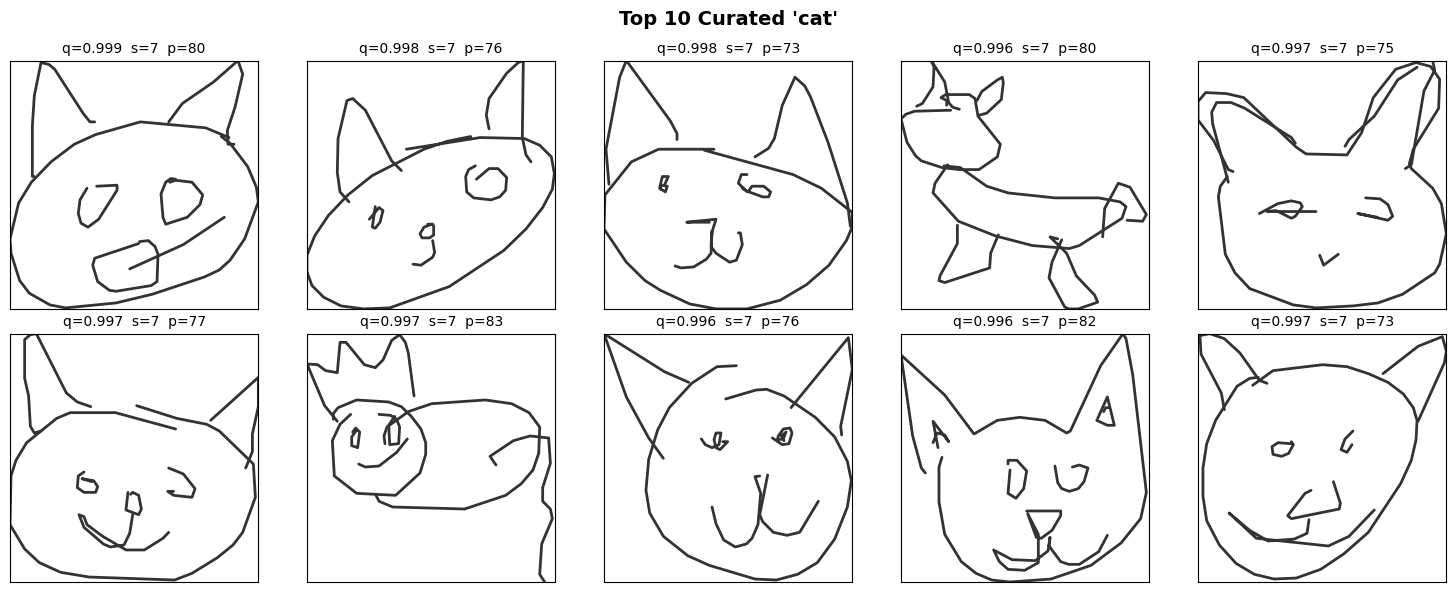

In [6]:
# Cell 2: Subject picker

# Browse available subjects by category
for category, subjects in SUBJECT_CATEGORIES.items():
    print(f"\n{category} ({len(subjects)}):")
    print(f"  {', '.join(subjects)}")

# ---- EDIT THIS ----
SUBJECT = "cat"
# -------------------

# Load curated data for this subject
curated = get_curated(SUBJECT, limit=50)
# print(f"\nSelected: '{SUBJECT}'")
# print(f"Loaded {len(curated)} curated compositions")

if curated:
    fig = draw_grid(curated[:10], cols=5, title=f"Top 10 Curated '{SUBJECT}'")
    plt.show()

In [8]:
# Cell 3: Plugin configuration — EDIT THESE to experiment

# ---- TOGGLE PLUGINS ON/OFF ----

# Style plugin (appends to system prompt)
USE_STYLE = True
STYLE = "cartoon"  # Options: minimalist, detailed, cartoon, sketch, geometric, or custom string

# Complexity plugin (appends to system prompt)
USE_COMPLEXITY = True
COMPLEXITY = "complex"  # Options: simple, moderate, complex, or custom string

# Subject tips plugin (appends to user prompt)
USE_SUBJECT_TIPS = True

# Few-shot plugin (adds conversation turns from curated data)
USE_FEW_SHOT = True
FEW_SHOT_COUNT = 6  # How many curated examples to use (chunked into pairs of 2)

# Generation parameters
PER_CALL = 5       # Compositions per API call (keep small! 1-5)
MAX_TOKENS = 8192  # Max output tokens

# ---- BUILD PROMPTS ----

system_plugins = []
if USE_STYLE:
    system_plugins.append(style_plugin(STYLE))
if USE_COMPLEXITY:
    system_plugins.append(complexity_plugin(COMPLEXITY))

system_prompt = combine_system_prompt(CLAUDE_SYSTEM_PROMPT, system_plugins)

user_plugins = []
if USE_SUBJECT_TIPS:
    tip = subject_tips_plugin(SUBJECT)
    if tip:
        user_plugins.append(tip)

user_prompt = combine_user_prompt(build_user_prompt(SUBJECT, PER_CALL), user_plugins)

# Few-shot pairs
few_shot_pairs = []
if USE_FEW_SHOT and curated:
    few_shot_comps = curated[:FEW_SHOT_COUNT]
    few_shot_pairs = build_few_shot_pairs_from_curated(SUBJECT, few_shot_comps)

print("=== Active Plugins ===")
if USE_STYLE:
    print(f"  Style: {STYLE}")
if USE_COMPLEXITY:
    print(f"  Complexity: {COMPLEXITY}")
if USE_SUBJECT_TIPS and subject_tips_plugin(SUBJECT):
    print(f"  Subject tips: ON")
if USE_FEW_SHOT and few_shot_pairs:
    print(f"  Few-shot: {len(few_shot_pairs)} pairs from {len(few_shot_comps)} examples")
if not any([USE_STYLE, USE_COMPLEXITY, USE_SUBJECT_TIPS and subject_tips_plugin(SUBJECT), USE_FEW_SHOT and few_shot_pairs]):
    print("  (none — using base prompts only)")
print(f"\nSystem prompt: {len(system_prompt):,} chars")
print(f"User prompt: {len(user_prompt):,} chars")
print(f"Per call: {PER_CALL} compositions")

=== Active Plugins ===
  Style: cartoon
  Complexity: complex
  Subject tips: ON
  Few-shot: 3 pairs from 6 examples

System prompt: 1,395 chars
User prompt: 317 chars
Per call: 5 compositions


In [9]:
# Cell 4: Generate — single Claude API call

t0 = time.time()

if few_shot_pairs:
    ai_comps, usage = call_claude_with_few_shot(
        system_prompt=system_prompt,
        few_shot_pairs=few_shot_pairs,
        user_prompt=user_prompt,
        max_tokens=MAX_TOKENS,
        tracker=tracker,
    )
else:
    ai_comps, usage = call_claude(
        system_prompt=system_prompt,
        user_prompt=user_prompt,
        max_tokens=MAX_TOKENS,
        tracker=tracker,
    )

elapsed = time.time() - t0

generated = [ai_to_composition(ac, generation_method="notebook-claude-sonnet") for ac in ai_comps]

print(f"Generated {len(generated)} compositions in {elapsed:.1f}s")
print(f"Tokens: {usage['input_tokens']:,} in / {usage['output_tokens']:,} out | Stop: {usage['stop_reason']}")
this_cost = usage['input_tokens'] * 3.00 / 1_000_000 + usage['output_tokens'] * 15.00 / 1_000_000
print(f"This call: ${this_cost:.4f}")
print(f"Session total: {tracker.summary()}")
print()

for i, comp in enumerate(generated):
    is_valid, score = validate(comp)
    print(f"  [{i}] valid={is_valid}, score={score:.4f}, strokes={count_strokes(comp)}, points={count_points(comp)}")

Generated 5 compositions in 75.2s
Tokens: 5,893 in / 6,183 out | Stop: end_turn
This call: $0.1104
Session total: Calls: 1 | Input: 5,893 tokens ($0.0177) | Output: 6,183 tokens ($0.0927) | Total: $0.1104

  [0] valid=True, score=0.9649, strokes=11, points=97
  [1] valid=True, score=0.9637, strokes=10, points=114
  [2] valid=True, score=0.9559, strokes=11, points=107
  [3] valid=True, score=0.9370, strokes=10, points=117
  [4] valid=True, score=0.9175, strokes=12, points=136


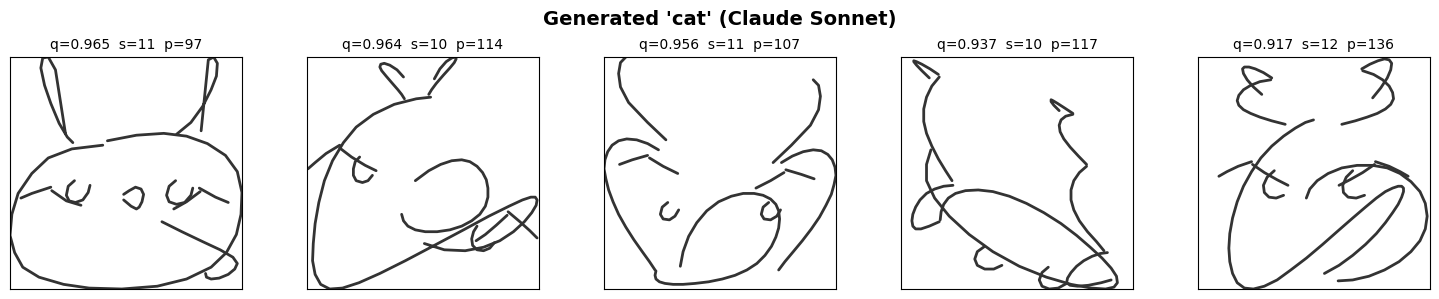

In [10]:
# Cell 5: Visualize generated compositions
if generated:
    fig = draw_grid(generated, cols=min(len(generated), 5), title=f"Generated '{SUBJECT}' (Claude Sonnet)")
    plt.show()
else:
    print("No compositions generated.")

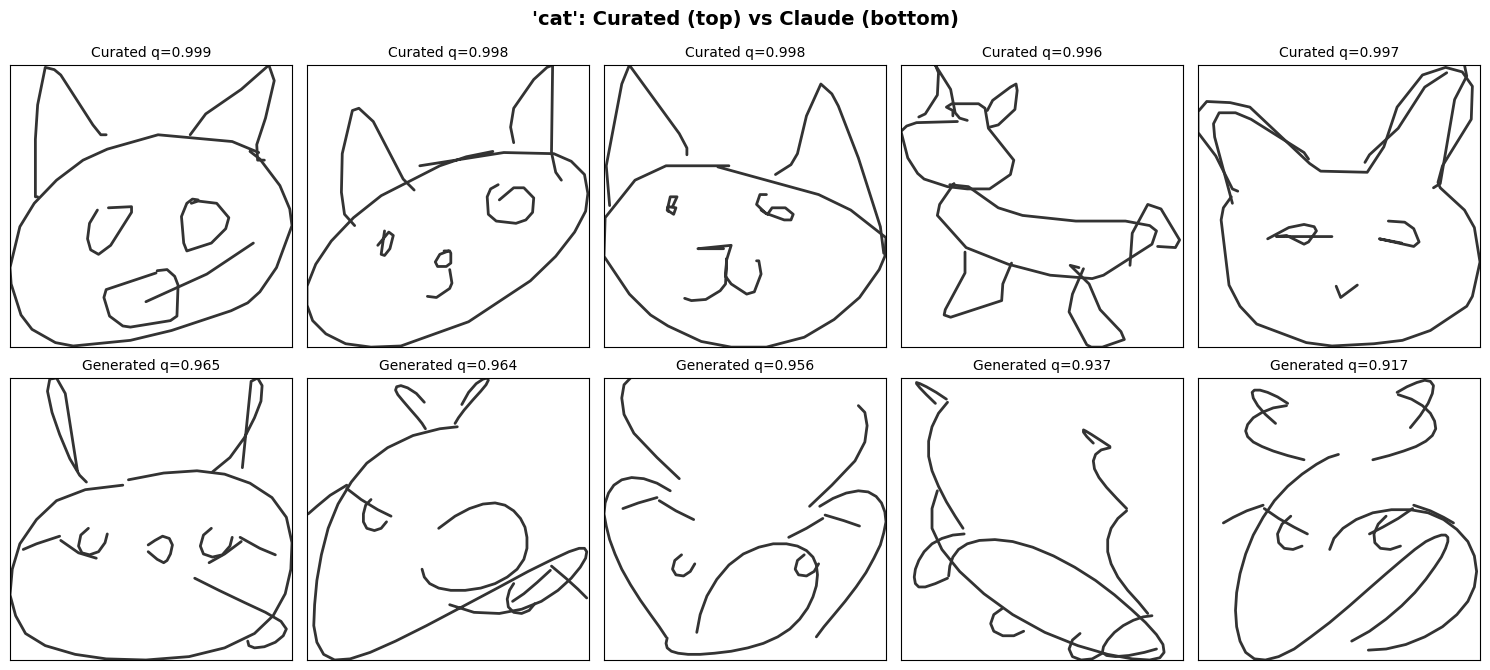

In [11]:
# Cell 6: Side-by-side comparison — curated vs Claude
if generated and curated:
    fig = draw_comparison(
        curated[:5], generated[:5],
        cols=5, title=f"'{SUBJECT}': Curated (top) vs Claude (bottom)"
    )
    plt.show()

In [8]:
# Cell 7: Detailed score breakdown
for i, comp in enumerate(generated):
    breakdown = score_breakdown(comp)
    print(f"\n=== Composition {i} ===")
    for key, val in breakdown.items():
        print(f"  {key}: {val}")


=== Composition 0 ===
  total_strokes: 10
  total_points: 93
  bbox: (0.0, 0.0, 1.0, 0.94)
  bbox_coverage: 0.94
  stroke_score: 0.85
  point_score: 0.974
  coverage_score: 1.0
  balance_score: 0.94
  final_score: 0.9556
  weights: stroke=0.15, point=0.15, coverage=0.40, balance=0.30

=== Composition 1 ===
  total_strokes: 9
  total_points: 88
  bbox: (0.01, 0.0, 0.99, 1.0)
  bbox_coverage: 0.98
  stroke_score: 0.9
  point_score: 0.984
  coverage_score: 1.0
  balance_score: 0.98
  final_score: 0.9766
  weights: stroke=0.15, point=0.15, coverage=0.40, balance=0.30

=== Composition 2 ===
  total_strokes: 10
  total_points: 93
  bbox: (0.0, 0.0, 1.0, 1.0)
  bbox_coverage: 1.0
  stroke_score: 0.85
  point_score: 0.974
  coverage_score: 1.0
  balance_score: 1.0
  final_score: 0.9736
  weights: stroke=0.15, point=0.15, coverage=0.40, balance=0.30


In [9]:
# Cell 8: Plugin comparison — generate with different style presets
# WARNING: This makes 3 API calls! Check tracker.summary() for running cost.

styles_to_test = ["minimalist", "detailed", "cartoon"]
style_results = {}

for style_name in styles_to_test:
    sp = combine_system_prompt(CLAUDE_SYSTEM_PROMPT, [style_plugin(style_name)])
    up = build_user_prompt(SUBJECT, 2)  # Only 2 per style to save cost

    t0 = time.time()
    try:
        ai_comps_s, usage_s = call_claude(
            system_prompt=sp, user_prompt=up, max_tokens=MAX_TOKENS, tracker=tracker,
        )
        elapsed_s = time.time() - t0
        comps_s = [ai_to_composition(ac, generation_method=f"notebook-claude-{style_name}") for ac in ai_comps_s]
        scores_s = [validate(c)[1] for c in comps_s if validate(c)[0]]
        style_results[style_name] = {
            "compositions": comps_s,
            "scores": scores_s,
            "avg_score": sum(scores_s) / len(scores_s) if scores_s else 0,
            "elapsed": elapsed_s,
            "usage": usage_s,
        }
        cost_s = usage_s['input_tokens'] * 3.00 / 1e6 + usage_s['output_tokens'] * 15.00 / 1e6
        print(f"  {style_name}: {len(scores_s)} valid, avg={style_results[style_name]['avg_score']:.4f}, ${cost_s:.4f}, {elapsed_s:.1f}s")
    except Exception as e:
        print(f"  {style_name}: ERROR — {e}")
        style_results[style_name] = {"compositions": [], "scores": [], "avg_score": 0, "elapsed": 0, "usage": {}}

print(f"\nSession total: {tracker.summary()}")

  minimalist: 2 valid, avg=0.6507, $0.0231, 15.8s
  detailed: 2 valid, avg=0.6825, $0.0486, 33.2s
  cartoon: 2 valid, avg=0.8126, $0.0306, 22.8s

Session total: Calls: 4 | Input: 8,217 tokens ($0.0247) | Output: 9,359 tokens ($0.1404) | Total: $0.1650


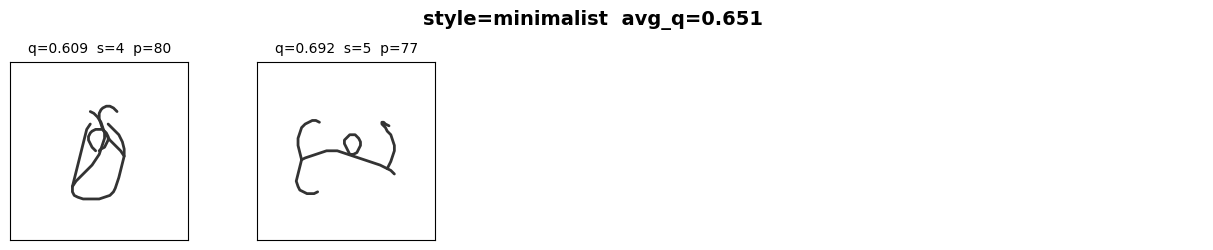

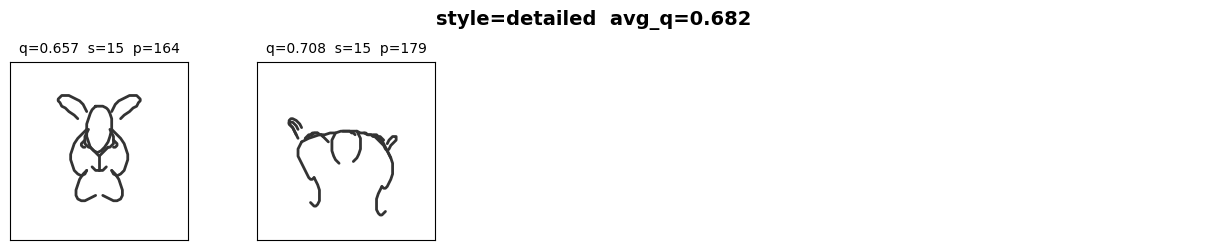

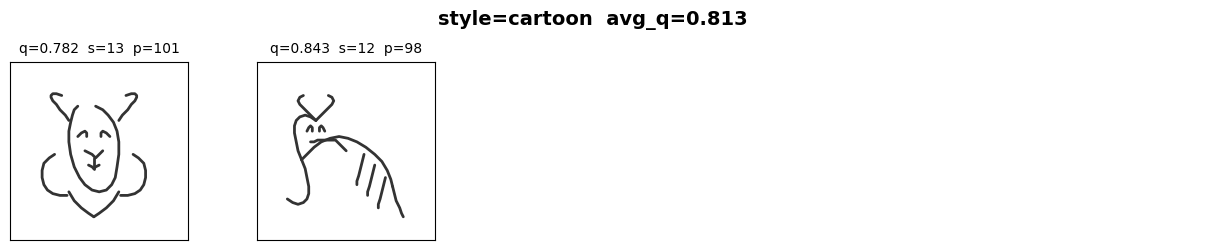

In [10]:
# Cell 9: Visualize style comparison
for style_name in styles_to_test:
    result = style_results.get(style_name)
    if result and result["compositions"]:
        fig = draw_grid(
            result["compositions"][:5], cols=5,
            title=f"style={style_name}  avg_q={result['avg_score']:.3f}",
            figsize_per_cell=2.5,
        )
        plt.show()

  Call 1/3: 2 valid, $0.0586, 30.2s
  Call 2/3: 2 valid, $0.0553, 28.8s
  Call 3/3: 2 valid, $0.0504, 27.3s

Total valid: 6
Session total: Calls: 7 | Input: 25,662 tokens ($0.0770) | Output: 16,824 tokens ($0.2524) | Total: $0.3293


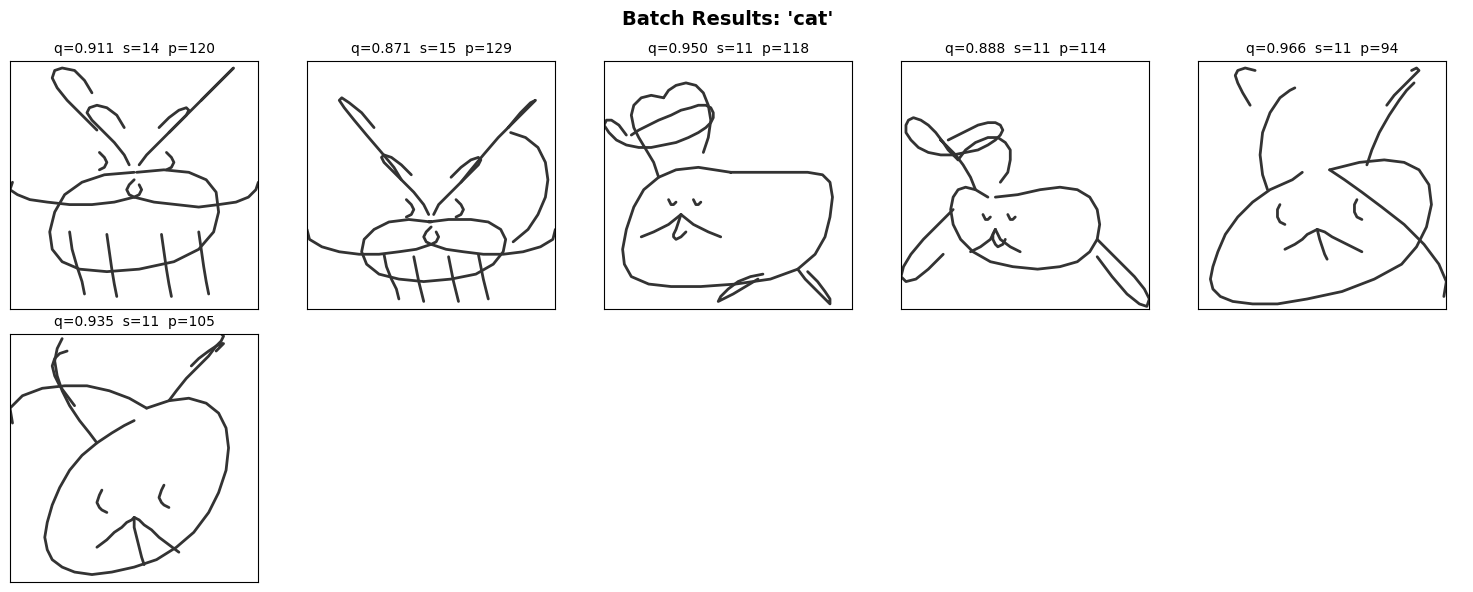

In [11]:
# Cell 10: Batch generation — multiple small calls with accumulation
# Generate a little at a time, not 1000 at once

BATCH_CALLS = 3        # Number of API calls to make
BATCH_PER_CALL = 2     # Compositions per call

all_generated = []

for call_num in range(BATCH_CALLS):
    t0 = time.time()
    batch_user_prompt = combine_user_prompt(build_user_prompt(SUBJECT, BATCH_PER_CALL), user_plugins)
    try:
        if few_shot_pairs:
            ais, u = call_claude_with_few_shot(
                system_prompt=system_prompt,
                few_shot_pairs=few_shot_pairs,
                user_prompt=batch_user_prompt,
                max_tokens=MAX_TOKENS,
                tracker=tracker,
            )
        else:
            ais, u = call_claude(
                system_prompt=system_prompt,
                user_prompt=batch_user_prompt,
                max_tokens=MAX_TOKENS,
                tracker=tracker,
            )
        elapsed = time.time() - t0
        comps = [ai_to_composition(ac, generation_method="notebook-claude-sonnet") for ac in ais]
        valid = [c for c in comps if validate(c)[0]]
        all_generated.extend(valid)
        cost = u['input_tokens'] * 3.00 / 1e6 + u['output_tokens'] * 15.00 / 1e6
        print(f"  Call {call_num + 1}/{BATCH_CALLS}: {len(valid)} valid, ${cost:.4f}, {elapsed:.1f}s")
    except Exception as e:
        print(f"  Call {call_num + 1}/{BATCH_CALLS}: ERROR — {e}")

print(f"\nTotal valid: {len(all_generated)}")
print(f"Session total: {tracker.summary()}")

if all_generated:
    fig = draw_grid(all_generated[:10], cols=5, title=f"Batch Results: '{SUBJECT}'")
    plt.show()

In [12]:
# Cell 11: Save good results to database
# Only run when you're happy with the generated output!

to_save = [c for c in all_generated if validate(c)[0]]
print(f"{len(to_save)} valid compositions ready to save")
print(f"Session cost so far: {tracker.summary()}")

# Uncomment the next two lines to actually save:
# saved = save_compositions(SUBJECT, to_save, generation_method="notebook-claude-sonnet")
# print(f"Saved {saved} compositions to database")

6 valid compositions ready to save
Session cost so far: Calls: 7 | Input: 25,662 tokens ($0.0770) | Output: 16,824 tokens ($0.2524) | Total: $0.3293


In [12]:
# Cell 12: Session cost summary
print("=== Session Cost Summary ===")
print(tracker.summary())
print(f"\nFor reference (Claude Sonnet 4.5):")
print(f"  Input:  $3.00 / 1M tokens")
print(f"  Output: $15.00 / 1M tokens")
print(f"  Typical call (~2K in, ~3K out): ~${2000 * 3.00 / 1e6 + 3000 * 15.00 / 1e6:.4f}")

=== Session Cost Summary ===
Calls: 1 | Input: 5,893 tokens ($0.0177) | Output: 6,183 tokens ($0.0927) | Total: $0.1104

For reference (Claude Sonnet 4.5):
  Input:  $3.00 / 1M tokens
  Output: $15.00 / 1M tokens
  Typical call (~2K in, ~3K out): ~$0.0510


## Tips for Claude Sonnet Tuning

1. **Cost awareness** — Each Cell 4 call costs roughly $0.05-$0.10. Check the tracker before running sweeps.
2. **Start small** — Use PER_CALL=1 or 2 when experimenting. Scale up only for batch saves.
3. **Plugins are additive** — Each enabled plugin adds text to the prompt. Too many may conflict.
4. **Few-shot is powerful** — The quality jump from 6+ curated examples is significant.
5. **Style presets** — `minimalist` produces fewer strokes, `detailed` produces more. Match to your subject.
6. **Custom tips** — Add entries to `SUBJECT_TIPS` dict in the plugins cell for subjects you work with often.
7. **Compare with Ollama** — Run `angel_tuning.ipynb` on the same subject to compare quality vs cost.